In [1]:
pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import nltk
import keras  # only for loading the dataset and preprocessing
import keras_preprocessing
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from gensim.models import word2vec, KeyedVectors
from sklearn.model_selection import train_test_split
import gensim.downloader
import re
from nltk.corpus import stopwords
import time
from torchinfo import summary
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
# connect to google drive
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/SIT coursework/667 Homeworks/Final Project"

os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['data',
 'regulationword2vec_mincount1-300.model',
 'output',
 'pretrained_data_for_CNN_LSTM.csv',
 'pretrained_test_data_for_CNN_LSTM.csv',
 'TFIDF_Sklearn_SVC_NB_LR.ipynb',
 'Pretrained_Bert_Pytrochlightning.ipynb',
 'answer_w2vcnnlstm.csv',
 'CNN+DenseLayer.ipynb',
 'Copy of BOW_NAIVE_BASELINE_model.ipynb',
 'BOW_NAIVE_BASELINE_model.ipynb',
 'Embedding+CNN+DenseLayer.ipynb',
 'CNN+LSTM+DenseLayer.ipynb']

In [4]:
df = pd.read_csv('./data/train_final.csv')
df.drop('Unnamed: 0', axis =1, inplace = True)
df['context'] = df['name'] + '. ' + df['document_text']

test_df = pd.read_csv('./data/test.csv')
test_df['context'] = test_df['name'] + '. ' + test_df['document_text']

In [5]:
# generate target columns
label_cols = [col for col in df.columns if col not in ['id', 'name', 'document_text', 'context']]
label_cols

['Accounting and Finance',
 'Antitrust',
 'Banking',
 'Broker Dealer',
 'Commodities Trading',
 'Compliance Management',
 'Consumer protection',
 'Contract Provisions',
 'Corporate Communications',
 'Corporate Governance',
 'Definitions',
 'Delivery',
 'Examinations',
 'Exemptions',
 'Fees and Charges',
 'Financial Accounting',
 'Financial Crime',
 'Forms',
 'Fraud',
 'IT Risk',
 'Information Filing',
 'Insurance',
 'Legal',
 'Legal Proceedings',
 'Licensing',
 'Licensure and certification',
 'Liquidity Risk',
 'Listing',
 'Market Abuse',
 'Market Risk',
 'Monetary and Economic Policy',
 'Money Services',
 'Money-Laundering and Terrorist Financing',
 'Natural Disasters',
 'Payments and Settlements',
 'Powers and Duties',
 'Quotation',
 'Records Maintenance',
 'Regulatory Actions',
 'Regulatory Reporting',
 'Required Disclosures',
 'Research',
 'Risk Management',
 'Securities Clearing',
 'Securities Issuing',
 'Securities Management',
 'Securities Sales',
 'Securities Settlement',
 'Tra

(array([2959., 1195.,  456.,  215.,   80.,   49.,   22.,   11.,    3.,
           3.]),
 array([  59. ,  181.6,  304.2,  426.8,  549.4,  672. ,  794.6,  917.2,
        1039.8, 1162.4, 1285. ]),
 <a list of 10 Patch objects>)

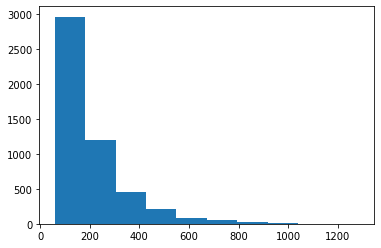

In [6]:
# find out the distribution of context lengths
from collections import Counter
import matplotlib.pyplot as plt
def bag_of_words(text):
    # TODO: Implement bag of words
    return len(text.split(' '))
plt.hist(test_df['context'].apply(bag_of_words))

In [7]:
#define preprocessing code for further use

def clean_text(text):
    if text == None:
        return None
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('\d+', ' ', text)
    text = re.sub('_+', ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.strip(' ')
    
    return text

def tokenizer(text):
    sentences = nltk.sent_tokenize(text)

    sentences = [nltk.word_tokenize(sentence) for sentence in sentences]

    for i in range(len(sentences)):
        sentences[i] = [word for word in sentences[i] if word not in stopwords.words('english')]
    
    return sentences[0]

In [8]:
df['context'] = df['context'].map(lambda con: tokenizer(clean_text(con)))
test_df['context'] = test_df['context'].map(lambda con: tokenizer(clean_text(con)))

In [9]:
my_word2vec = word2vec.Word2Vec.load('regulationword2vec_mincount1-300.model')

In [10]:
weights = torch.FloatTensor(my_word2vec.wv.vectors)

In [11]:
df['pretrained'] = df['context'].map(lambda li: pd.Series(li).map(lambda word: my_word2vec.wv.index2word.index(word)))
test_df['pretrained'] = test_df['context'].map(lambda li: pd.Series(li).map(lambda word: my_word2vec.wv.index2word.index(word)))

In [12]:
train_df, eval_df = train_test_split(df, train_size = 0.8,test_size = 0.2, random_state=42)

In [13]:
DOC_LEN = 384
train_x = keras.utils.pad_sequences(train_df['pretrained'],
                                    value=0,
                                    padding='post',
                                    maxlen=DOC_LEN)

eval_x = keras.utils.pad_sequences(eval_df['pretrained'],
                                    value=0,
                                    padding='post',
                                    maxlen=DOC_LEN)

test_x = keras.utils.pad_sequences(test_df['pretrained'],
                                    value=0,
                                    padding='post',
                                    maxlen=DOC_LEN)

print(train_x.shape)
print(eval_x.shape)
print(test_x.shape)

(7887, 384)
(1972, 384)
(4993, 384)


In [14]:
class RegulationDataset(Dataset):
    def __init__(self, features, dataframe):
        self.dataframe = dataframe
        self.features = torch.IntTensor(features)

    def __len__(self):
        return len(self.dataframe)
      
    def __getitem__(self, index):        
        data_row = self.dataframe.iloc[index]

        labels = data_row[label_cols]

        return self.features[index], torch.FloatTensor(labels)

class RegulationTestDataset(Dataset):
    def __init__(self, features):
        self.features = torch.IntTensor(features)

    def __len__(self):
        return len(self.features)
      
    def __getitem__(self, index):        
        return self.features[index]

# datasets
train_dataset = RegulationDataset(train_x, train_df)

eval_dataset = RegulationDataset(eval_x, eval_df)

test_dataset = RegulationTestDataset(test_x)

In [15]:
class Baseline(nn.Module):
    def __init__(self, weights, embedding_dim, hidden_layer1, hidden_layer2):
        super(Baseline, self).__init__()
        self.weights = weights
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding.from_pretrained(self.weights)

  
        self.classifier = nn.Sequential( 
            nn.Flatten(), # define a subcomponent of neural network or another to define model
            nn.Linear(in_features=embedding_dim*384, out_features=hidden_layer1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=hidden_layer1, out_features=hidden_layer2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=hidden_layer2, out_features=50),
      
          )
        
    def forward(self, x):
        x = self.embedding(x)

        return self.classifier(x)

In [16]:
Baseline_model = Baseline(weights, 300, 50, 10)

In [27]:
summary(Baseline_model)

Layer (type:depth-idx)                   Param #
Baseline                                 --
├─Embedding: 1-1                         (10,341,900)
├─Sequential: 1-2                        --
│    └─Flatten: 2-1                      --
│    └─Linear: 2-2                       5,760,050
│    └─ReLU: 2-3                         --
│    └─Dropout: 2-4                      --
│    └─Linear: 2-5                       510
│    └─ReLU: 2-6                         --
│    └─Dropout: 2-7                      --
│    └─Linear: 2-8                       550
Total params: 16,103,010
Trainable params: 5,761,110
Non-trainable params: 10,341,900

In [17]:
class TextCNN(nn.Module):
    def __init__(self, weights, embedding_dim, out_channels, dropout_ratio):
        super(TextCNN, self).__init__()
        self.weights = weights
        self.embedding_dim = embedding_dim
        self.dropout_ratio = dropout_ratio
        
        # embedding
        self.embedding = nn.Embedding.from_pretrained(self.weights)  # (-1, DOC_LEN, embedding_dim), num_embedding: embedding dict size, embedding_dim: length of embedding vector
        
        # 1D CNN
        # unigram
        self.unigram = nn.Sequential(# input (-1, embedding_dim, DOC_LEN)
        nn.Conv1d(in_channels=embedding_dim, out_channels=out_channels, kernel_size=2),  # (-1, 64, DOC_LEN)
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=DOC_LEN - 2 + 1),  # (-1, 64, 1)
        nn.Flatten()  # (-1, 64 * 1)
        )
        # bigram
        self.bigram = nn.Sequential(# input (-1, embedding_dim, DOC_LEN)
        nn.Conv1d(in_channels=embedding_dim, out_channels=out_channels, kernel_size=3),  # (-1, 64, DOC_LEN-2+1) ??? why DOC_LEN - 2 + 1
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=DOC_LEN - 3 + 1),  # (-1, 64, 1)
        nn.Flatten()  # (-1, 64 * 1)
        )
        # trigram
        self.trigram = nn.Sequential(# input (-1, embedding_dim, DOC_LEN)
        nn.Conv1d(in_channels=embedding_dim, out_channels=out_channels, kernel_size=4),  # (-1, 64, DOC_LEN-3+1)
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=DOC_LEN - 4 + 1),  # (-1, 16, 7)
        nn.Flatten()  # (-1, 64 * 1)
        )
        # simple classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_ratio),
            nn.Linear(in_features=out_channels*3, out_features=50)
        )
    def forward(self, x):
        # get embedding
        x = self.embedding(x)
        # make sure we are convolving on each word
        x = torch.transpose(x, dim0=1, dim1=2)  # (-1, DOC_LEN, embedding_dim): embedding on 1(DOC_LEN) & 2(embedding_dim) dims
        # 1d cnn output
        uni_gram_output = self.unigram(x)
        bi_gram_output = self.bigram(x)
        tri_gram_output = self.trigram(x)

        # concatenate
        x = torch.cat((uni_gram_output, bi_gram_output, tri_gram_output), dim=1)
        # classifier
        x = self.classifier(x)

        return x

In [18]:
CNN_model = TextCNN(weights, 300, 1024, 0.3)

In [28]:
summary(CNN_model)

Layer (type:depth-idx)                   Param #
TextCNN                                  --
├─Embedding: 1-1                         (10,341,900)
├─Sequential: 1-2                        --
│    └─Conv1d: 2-1                       615,424
│    └─ReLU: 2-2                         --
│    └─MaxPool1d: 2-3                    --
│    └─Flatten: 2-4                      --
├─Sequential: 1-3                        --
│    └─Conv1d: 2-5                       922,624
│    └─ReLU: 2-6                         --
│    └─MaxPool1d: 2-7                    --
│    └─Flatten: 2-8                      --
├─Sequential: 1-4                        --
│    └─Conv1d: 2-9                       1,229,824
│    └─ReLU: 2-10                        --
│    └─MaxPool1d: 2-11                   --
│    └─Flatten: 2-12                     --
├─Sequential: 1-5                        --
│    └─Dropout: 2-13                     --
│    └─Linear: 2-14                      153,650
Total params: 13,263,422
Trainable para

In [19]:
class CNN_LSTM(nn.Module):

    def __init__(self, weights, embedding_dim, out_channels, DOC_LEN, lstm_hidden_dim, dropout_ratio, n_layers, output_size):
        super(CNN_LSTM, self).__init__()
        self.weights = weights
        self.embedding_dim = embedding_dim
        self.out_channels = out_channels
        #self.out_features = out_features
        self.DOC_LEN = DOC_LEN
        self.lstm_hidden_dim = lstm_hidden_dim
        self.dropout_ratio = dropout_ratio
        self.n_layers = n_layers
        self.output_size = output_size
        
        # embedding
        self.embedding = nn.Embedding.from_pretrained(self.weights)  # (-1, DOC_LEN, embedding_dim), num_embedding: embedding dict size, embedding_dim: length of embedding vector
        
        # 1D CNN
        # unigram
        self.unigram = nn.Sequential(# input (-1, embedding_dim, DOC_LEN)
        nn.Conv1d(in_channels=self.embedding_dim, out_channels=self.out_channels, kernel_size=2),  
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=DOC_LEN - 2 + 1), 
        #nn.Flatten()  
        )
        # bigram
        self.bigram = nn.Sequential(# input (-1, embedding_dim, DOC_LEN)
        nn.Conv1d(in_channels=self.embedding_dim, out_channels=self.out_channels, kernel_size=3),  
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=DOC_LEN - 3 + 1), 
        #nn.Flatten()  
        )
        # trigram
        self.trigram = nn.Sequential(# input (-1, embedding_dim, DOC_LEN)
        nn.Conv1d(in_channels=self.embedding_dim, out_channels=self.out_channels, kernel_size=4),  
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=DOC_LEN - 4 + 1), 
        #nn.Flatten()
        )

        # LSTM layer 
        
        self.lstm = nn.LSTM(input_size=self.out_channels*3, hidden_size=self.lstm_hidden_dim,
                           num_layers=self.n_layers, batch_first=True, bidirectional=True)


        # linear and sigmoid layer. If bidictional is True, double the input dimension
        self.classifier = nn.Sequential(
            nn.Dropout(self.dropout_ratio),
            nn.ReLU(),
            nn.Linear(in_features=self.lstm_hidden_dim*2, out_features=self.output_size)
                      )
        
    def forward(self, x):
        # get embedding
        x = self.embedding(x)
        # make sure we are convolving on each word
        x = x.permute(0, 2, 1)
        #x = torch.transpose(x, dim0=1, dim1=2)  # (-1, DOC_LEN, embedding_dim): embedding on 1(DOC_LEN) & 2(embedding_dim) dims
        # 1d cnn output
        uni_gram_output = self.unigram(x)
        bi_gram_output = self.bigram(x)
        tri_gram_output = self.trigram(x)
        #x = self.unigram(x)
        # concatenate
        x = torch.cat((uni_gram_output, bi_gram_output, tri_gram_output), dim=1)

        # Passing in the input and hidden state into the model and obtaining outputs
        x = x.permute(0, 2, 1)
        lstm_out, hidden = self.lstm(x)
        # classifier
        out = self.classifier(lstm_out[:,:].squeeze())
       
        return out

In [20]:
CNN_LSTM_model = CNN_LSTM(weights = weights, embedding_dim=300, out_channels=64, DOC_LEN=DOC_LEN, lstm_hidden_dim=128, dropout_ratio=0.5, n_layers=1, output_size=50)

In [ ]:
summary(CNN_LSTM_model)

Layer (type:depth-idx)                   Param #
CNN_LSTM                                 --
├─Embedding: 1-1                         (10,341,900)
├─Sequential: 1-2                        --
│    └─Conv1d: 2-1                       38,464
│    └─ReLU: 2-2                         --
│    └─MaxPool1d: 2-3                    --
├─Sequential: 1-3                        --
│    └─Conv1d: 2-4                       57,664
│    └─ReLU: 2-5                         --
│    └─MaxPool1d: 2-6                    --
├─Sequential: 1-4                        --
│    └─Conv1d: 2-7                       76,864
│    └─ReLU: 2-8                         --
│    └─MaxPool1d: 2-9                    --
├─LSTM: 1-5                              329,728
├─Sequential: 1-6                        --
│    └─Dropout: 2-10                     --
│    └─ReLU: 2-11                        --
│    └─Linear: 2-12                      12,850
Total params: 10,857,470
Trainable params: 515,570
Non-trainable params: 10,341,900

In [21]:
def train_model(model, train_dataset, test_dataset, device, lr=0.0001, epochs=20, batch_size=32):
    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # move model to device
    model = model.to(device)

    # history
    history = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}

    # setup loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0005)

    # training loop
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        for x, y in train_loader:
            # move data to device
            x = x.to(device)
            y = y.to(device)
            # forward
            outputs = model(x)
            pred = torch.round(torch.sigmoid(outputs))
            cur_train_loss = criterion(outputs, y)
            cur_train_acc = (pred == y).float().mean().item() 
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # loss and acc
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # test start
        model.eval()
        with torch.no_grad():
            for x, y in test_loader:
                # move
                x = x.to(device)
                y = y.to(device)
                # predict
                outputs = model(x)
                pred = torch.round(torch.sigmoid(outputs))
                cur_test_loss = criterion(outputs, y)
                cur_test_acc = (pred == y).float().mean().item() 
                # loss and acc
                test_loss += cur_test_loss
                test_acc += cur_test_acc

        # epoch output
        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        val_loss = (test_loss/len(test_loader)).item()
        val_acc = test_acc/len(test_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(val_loss)
        history['test_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.4f} train_acc:{train_acc:.4f}, valid loss:{val_loss:.4f} valid acc:{val_acc:.5f}")
    
    return history

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
device

device(type='cuda')

In [24]:
Baseline_history = train_model(model=Baseline_model,
                      train_dataset=train_dataset,
                      test_dataset=eval_dataset,
                      device=device,
                      lr=0.0005,
                      epochs=50,
                      batch_size=8)

Training Start
Epoch:1 / 50, train loss:0.4162 train_acc:0.8484, valid loss:0.3043 valid acc:0.90456
Epoch:2 / 50, train loss:0.3293 train_acc:0.9042, valid loss:0.3054 valid acc:0.90466
Epoch:3 / 50, train loss:0.3215 train_acc:0.9044, valid loss:0.3012 valid acc:0.90456
Epoch:4 / 50, train loss:0.3171 train_acc:0.9044, valid loss:0.2983 valid acc:0.90470
Epoch:5 / 50, train loss:0.3122 train_acc:0.9044, valid loss:0.2934 valid acc:0.90467
Epoch:6 / 50, train loss:0.3077 train_acc:0.9044, valid loss:0.2871 valid acc:0.90457
Epoch:7 / 50, train loss:0.3061 train_acc:0.9046, valid loss:0.2871 valid acc:0.90465
Epoch:8 / 50, train loss:0.3031 train_acc:0.9048, valid loss:0.2896 valid acc:0.90463
Epoch:9 / 50, train loss:0.2987 train_acc:0.9053, valid loss:0.2867 valid acc:0.90492
Epoch:10 / 50, train loss:0.2965 train_acc:0.9055, valid loss:0.2794 valid acc:0.90608
Epoch:11 / 50, train loss:0.2972 train_acc:0.9055, valid loss:0.2811 valid acc:0.90748
Epoch:12 / 50, train loss:0.2967 trai

In [25]:
CNN_history = train_model(model=CNN_model,
                      train_dataset=train_dataset,
                      test_dataset=eval_dataset,
                      device=device,
                      lr=0.0005,
                      epochs=50,
                      batch_size=8)

Training Start
Epoch:1 / 50, train loss:0.2105 train_acc:0.9285, valid loss:0.1585 valid acc:0.94211
Epoch:2 / 50, train loss:0.1375 train_acc:0.9508, valid loss:0.1294 valid acc:0.95161
Epoch:3 / 50, train loss:0.1221 train_acc:0.9560, valid loss:0.1236 valid acc:0.95420
Epoch:4 / 50, train loss:0.1162 train_acc:0.9580, valid loss:0.1198 valid acc:0.95714
Epoch:5 / 50, train loss:0.1131 train_acc:0.9590, valid loss:0.1177 valid acc:0.95849
Epoch:6 / 50, train loss:0.1110 train_acc:0.9599, valid loss:0.1158 valid acc:0.95751
Epoch:7 / 50, train loss:0.1095 train_acc:0.9606, valid loss:0.1172 valid acc:0.95910
Epoch:8 / 50, train loss:0.1083 train_acc:0.9610, valid loss:0.1138 valid acc:0.95859
Epoch:9 / 50, train loss:0.1073 train_acc:0.9614, valid loss:0.1125 valid acc:0.96046
Epoch:10 / 50, train loss:0.1070 train_acc:0.9614, valid loss:0.1136 valid acc:0.95858
Epoch:11 / 50, train loss:0.1063 train_acc:0.9616, valid loss:0.1116 valid acc:0.96001
Epoch:12 / 50, train loss:0.1064 trai

In [26]:
CNN_LSTM_history = train_model(model=CNN_LSTM_model,
                      train_dataset=train_dataset,
                      test_dataset=eval_dataset,
                      device=device,
                      lr=0.0005,
                      epochs=50,
                      batch_size=8)

Training Start
Epoch:1 / 50, train loss:0.3192 train_acc:0.9024, valid loss:0.2968 valid acc:0.90465
Epoch:2 / 50, train loss:0.2762 train_acc:0.9062, valid loss:0.2569 valid acc:0.90893
Epoch:3 / 50, train loss:0.2474 train_acc:0.9110, valid loss:0.2334 valid acc:0.91381
Epoch:4 / 50, train loss:0.2275 train_acc:0.9162, valid loss:0.2171 valid acc:0.91826
Epoch:5 / 50, train loss:0.2139 train_acc:0.9213, valid loss:0.2063 valid acc:0.92256
Epoch:6 / 50, train loss:0.2041 train_acc:0.9252, valid loss:0.1994 valid acc:0.92532
Epoch:7 / 50, train loss:0.1976 train_acc:0.9281, valid loss:0.1934 valid acc:0.92837
Epoch:8 / 50, train loss:0.1934 train_acc:0.9301, valid loss:0.1905 valid acc:0.93160
Epoch:9 / 50, train loss:0.1901 train_acc:0.9314, valid loss:0.1869 valid acc:0.93180
Epoch:10 / 50, train loss:0.1872 train_acc:0.9325, valid loss:0.1857 valid acc:0.93223
Epoch:11 / 50, train loss:0.1851 train_acc:0.9333, valid loss:0.1835 valid acc:0.93339
Epoch:12 / 50, train loss:0.1831 trai

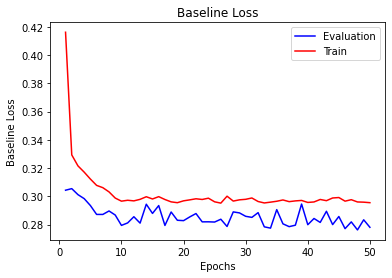

In [30]:
plt.plot(range(1, 51), Baseline_history['test_loss'],'b-', label='Evaluation')
plt.plot(range(1, 51), Baseline_history['train_loss'],'r-', label='Train')
plt.xlabel('Epochs')
plt.ylabel('Baseline Loss')
plt.legend()
plt.title("Baseline Loss")
plt.show()

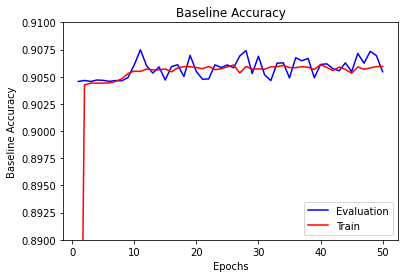

In [32]:
plt.plot(range(1, 51), Baseline_history['test_acc'],'b-', label='Evaluation')
plt.plot(range(1, 51), Baseline_history['train_acc'],'r-', label='Train')
plt.xlabel('Epochs')
plt.ylabel('Baseline Accuracy')
plt.ylim(0.89, 0.91)
plt.legend()
plt.title("Baseline Accuracy")
plt.show()

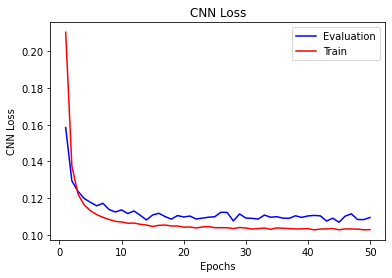

In [33]:
plt.plot(range(1, 51), CNN_history['test_loss'],'b-', label='Evaluation')
plt.plot(range(1, 51), CNN_history['train_loss'],'r-', label='Train')
plt.xlabel('Epochs')
plt.ylabel('CNN Loss')
plt.legend()
plt.title("CNN Loss")
plt.show()

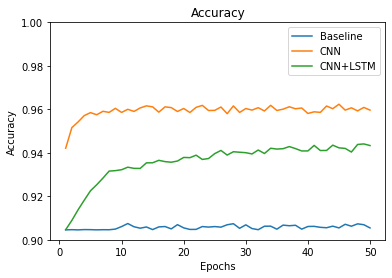

In [36]:
plt.plot(range(1, 51), Baseline_history['test_acc'], label='Baseline')
plt.plot(range(1, 51), CNN_history['test_acc'], label='CNN')
plt.plot(range(1, 51), CNN_LSTM_history['test_acc'], label='CNN+LSTM')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.9,1.0)
plt.legend()
plt.title("Accuracy")
plt.show()

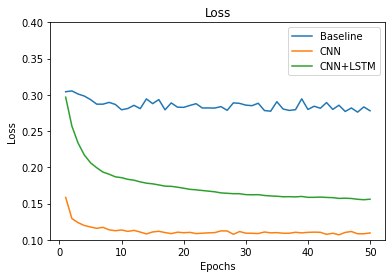

In [38]:
plt.plot(range(1, 51), Baseline_history['test_loss'], label='Baseline')
plt.plot(range(1, 51), CNN_history['test_loss'], label='CNN')
plt.plot(range(1, 51), CNN_LSTM_history['test_loss'], label='CNN+LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0.1,0.4)
plt.legend()
plt.title("Loss")
plt.show()

In [ ]:
pred_table = []
test_loader = DataLoader(test_dataset, batch_size=1)
model_C_L.to(device)
model_C_L.eval()
with torch.no_grad():
    for x in test_loader:
        # move
        x = x.to(device)
        # predict
        outputs = model_C_L(x)
        pred = torch.round(torch.sigmoid(outputs))
        pred_table.append(pred)

pred_df = []
def to_a(t):
    return t.cpu().detach().numpy().reshape(50)
for t in pred_table:
    pred_df.append(to_a(t))

test_pred = pd.DataFrame(pred_df)
test_pred.columns = label_cols
test_pred = test_pred.astype('int')
test_final = pd.concat([test_df,test_pred], axis=1)

id_table = []
for i in test_final['id']:
    for target in label_cols:
        id_table.append(str(i)+'_'+target)
        
prediction_table = []
for col, row in test_final.iterrows():
    for target in label_cols:
        prediction_table.append(row[target])

In [ ]:
answer = pd.concat([pd.DataFrame(id_table), pd.DataFrame(prediction_table)], axis =1)
answer.columns = ['id', 'predictions']
answer.to_csv('answer_w2vcnnlstm.csv', header=True, index=False)
answer

,id,predictions
0,4771_Accounting and Finance,0
1,4771_Antitrust,0
2,4771_Banking,0
3,4771_Broker Dealer,0
4,4771_Commodities Trading,0
...,...,...
249645,57235_Securities Management,0
249646,57235_Securities Sales,0
249647,57235_Securities Settlement,0
249648,57235_Trade Pricing,0
